# Multilayer perceptron

간단한 신경망으로 해봅시다! 

**contents**

1.   버전 체크
2.   신경망 기본 구조
3.   학습 및 모니터링
4.   과적합 Overfitting 해결
  
      4.1. 가중치 감소

      4.2. 드랍아웃

      4.3. 배치정규화

---


# 1. 버전 체크

현재 저는 2.8.2 버전이네요.

In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

# 2. Neural network

MNIST classification 예제입니다.

딥러닝 모델의 일반적인 구성은 다음과 같습니다.


1.   데이터 - 어떤 차원의 데이터가 들어오는지에 따라서 네트워크 구성도 달라집니다.
2.   신경망 구조 - Dense Layer 혹은 Conv layer 등 다른 네트워크 구조를 쓸 수가 있습니다.
3.   손실함수 Loss function  - 상황에 맞게 수정할 필요가 있습니다. 
4.   최적화 방법 Optimizer - backpropagation 을 어떻게 할 지 바꿔주며 수행해 볼 수 있습니다.

이번 notebook 에서는 간단한 neural network 를 만들어 MNIST 분류를 실제로 해봅시다.







## 2.1. 데이터

MNIST 데이터를 활용할 겁니다. 보통은 여러분 컴퓨터에 저장된 파일을 불러와서 사용하시겠지만, 여기서는 웹에서 MNIST 데이터를 직접 다운받아 활용하도록 하겠습니다.



In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


11501568/11490434 [==============================] - 0s 0us/step


input data x_train 은 (60000,28,28) 의 크기를 갖고 있습니다.

In [3]:
x_train.shape

(60000, 28, 28)

그리고 이 데이터를 텐서플로우에서 제공하는 Dataset 이라는 클래스로 옮깁니다.

우리는 60000개의 데이터를 한번에 넣지 않고 작은 batch로 뽑아서 네트워크를 학습 시킬겁니다. 그래야 효율적이니까요 (다른 중요한 이유들도 있지만 아직 다루지 않았습니다)

데이터를 이런 batch 단위로 묶는 것, 그리고 데이터를 뒤섞어주는 (stochastic gradient descent 같은데서도 중요한 부분이겠죠) 기능까지 있어서 유용하게 활용할 수 있습니다.

옛날엔 이게 없어서 일일히 index 지정해서 넣기도 했습니다.  

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 2.2. 신경망 구조

네트워크를 어떻게 구축하시든, 그건 여러분 마음입니다. 그렇지만 적어도 class 로 구성하는 연습을 해두시면 좋아요. 그래야 나중에 네트워크를 저장하고 다시 불러오는 과정들이 어렵지 않고, 상속하여 새로운 네트워크를 만들기도 쉽습니다.

---



텐서플로우는 케라스 라고 하는 딥러닝 라이브러를 포함하고 있습니다.

옛날에는 이게 별도의 라이브러리였는데, 텐서플로우로 통합됐어요.

이 케라스를 통한 네트워크 구성방법은 세가지가 있습니다.



*   Sequential 절차형 
*   Functional 함수형
*   Subclass   서브클래스 - 간단



과거의 텐서플로우는 복잡하게 하나하나 input $x$ 와 hidden layer 1의 값 $h_1$, 그리고 다시 그 다음 layer 의 activity 인 $h_2$ 와 연결하는 작업이 필요했었습니다. (Tensorflow version 0.12 이하, 1.X 버전에서도 그렇게 많이들 했구요.) 

근데 요즘은 케라스에서 제공하는 간단한 함수들로 구성할 수 있도록 많이 나오고 있어요. 이런걸 활용해 보겠습니다.

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [6]:
# Subclassing
# Keras 의 Model 을 상속받아 만듭니다. 꼭 이 형태로 해야하는건 아닌데, 이게 편해서 이렇게 많이 합니다.
class MLP_3L(Model):
  def __init__(self):
    # 상속
    # 파이썬 클래스 상속 받을 녀석의 속성 및 메서드 가져오기
    # 없으면 지금 DNN의 init 으로 덮어 씌워집니다. 
    super(MLP_3L, self).__init__() 

    # Flatten 
    # 데이터를 1차원으로 정렬합니다. (N,28,28) 이 (N,784)으로
    self.flatten = Flatten()

    # Dense layers
    # 활성함수는 activation 을 바꿔줌으로써 바꿀 수 있습니다.
    self.d1 = Dense(128, activation='sigmoid')
    self.d2 = Dense(10, activation='sigmoid')
    self.d3 = Dense(10)

    # Conv layers
    # Convolution neural network 에서는 Conv layer 를 쓰기도 합니다. 
    # self.flatten = Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
    # self.d1 = MaxPooling2D((2, 2))
    # self.d2 = Flatten()
    # self.d3 = Dense(128, activation='sigmoid')
    # self.d4 = Dense(10)


  def call(self, inputs):
    # call 은 이 Keras Model 을 상속받아 사용할때 쓰는 방식입니다. x가 들어오면 그것에 대해서 네트워크 연산해서 return 줍니다.
    x = self.flatten(inputs)
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

# 모델 생성
model = MLP_3L()


## 2.3. 손실함수 와 최적화

손실 함수 loss function 는 classification 문제에선 보통 cross entropy를 사용합니다.


In [7]:
# cross entropy를 사용합니다. 
# from_logits=True 는 아웃풋이 class 에 대한 확률값이 되도록 normalize 하겠다는 의미. 모두 더해서 1이되는 확률값을 코딩하도록 만듭니다.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 


경사 하강법 설명할 때도 말 했지만, Global minimum 을 찾는 것은 실제로 loss function 이 어떻게 정의 되었는지 모르는 상태에선 거의 불가능에 가깝죠 ($f(x)=x^2$ 처럼 알 수 있다면 좋으련만). 그래서 여러가지 optimizer 가 개발되어왔습니다. 

여기서는 우리가 익숙한 Gradient descent의 일종인 SGD(stochastic gradient descent)를 쓸게요.

In [8]:
# optimizer 사용하는 부분
optimizer = tf.keras.optimizers.SGD()

각각 training 과 test 의 metric (acc와 loss) 을 뽑는 메서드들을 불러와놓구요

In [9]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

training 하는 것에 대해서 메서드를 하나 만듭니다.

그냥 interpreter 로 실행하듯 해도 되는데 (약간 암산 잘하는 것), 이렇게 해야 좀 관리가 쉽겠죠?

In [10]:
def train_step(images, labels):
  # tf 2.x의 문법입니다. loss 를 저장하는 어떤 tape (기록장치) 이 있고 거기에 저장해놓고 backpropagation 하겠다 이런 의미입니다.
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

test 는 아시다시피 학습 training 과정에서 경험하지 못했던 test dataset 에 대해서 성능이 얼마나 좋은지/나쁜지를 보는 과정입니다. 과적합 overfitting 의 판단 기준이 되죠.


In [11]:
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

## 2.4. 학습 시작

드디어 네트워크 하나 돌려봅니다. 

`EPOCHS = 5` 는 에폭이 5개라는 뜻인데, 1 에폭은 주어진 데이터셋을 한번 전부 돌리는 것을 의미합니다. 

우리의 training data 가 60000,28,28 이었으니까, 한 에폭당 60000, 즉 네트워크는 데이터를 총 30만번 보게 되겠네요!

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 2.2270901203155518, Accuracy: 27.15833282470703, Test Loss: 2.097231864929199, Test Accuracy: 37.470001220703125
Epoch 2, Loss: 1.9062293767929077, Accuracy: 44.56500244140625, Test Loss: 1.693687915802002, Test Accuracy: 49.349998474121094
Epoch 3, Loss: 1.5226867198944092, Accuracy: 57.6150016784668, Test Loss: 1.3473405838012695, Test Accuracy: 63.11000061035156
Epoch 4, Loss: 1.2241953611373901, Accuracy: 67.99832916259766, Test Loss: 1.0958784818649292, Test Accuracy: 71.0
Epoch 5, Loss: 1.0179013013839722, Accuracy: 73.90833282470703, Test Loss: 0.929245114326477, Test Accuracy: 76.12000274658203


# 3. 학습 및 모니터링

학습을 진행해봅시다. 우리는 학습을 진행하면서 모니터링을 할 겁니다. 이 모니터링을 통해서, 웨이트가 어떻게 변화하는지 볼거고, 그래서 나중에 어떻게 조절해야하는지 까지 확인을 할 겁니다.

그러려면 네트워크 학습파트를 다시 정의 해야합니다. 
**왜?** 

텐서보드라는걸 쓸거고, 그러려면 텐서보드로 데이터를 저장할 값들을 만들어 줘야 합니다.

그리고 또, 이 값들을 실제로 *학습과정에서* 저장을 해야겠죠!



 ## 3.1. 일단 텐서보드 불러옵시다.

이렇게 하면 저장을 하는거에요 텐서보드에 보일 수 있게. 

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

## 3.2. 텐서보드에 저장할 수 있게 만듭시다

**저장할 값들?** 사실 우리가 이걸 앞에서 이미 만들었습니다.



>각각 training 과 test 의 metric (acc와 loss) 을 뽑는 메서드들을 불러와놓구요
```
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
```

**실제로 저장할 수 있도록 준비합니다**

In [ ]:
# 만약 이미 저장된 값이 있으면 지웁시다.
!rm -rf logs/ #logs  폴더에 저장할거에요

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'

# writer: 이게 실제로 파일을 저장하고 써주는 부분입니다. 
train_summary_writer = tf.summary.create_file_writer(train_log_dir) 
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

그리고 이제는 학습 부분을 손 봐야 합니다.

원래는 뭐 텐서보드 관련 summarywriter 이런게 없었어요

```
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )
```

그런데 이제는 여기에다가 summary writer를 집어 넣을 겁니다. 

In [ ]:
!ls logs/gradient_tape

20220915-104300


In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)


  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )
  # Reset metrics every epoch
  train_loss.reset_states()
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.9484335780143738, Accuracy: 75.82583618164062, Test Loss: 0.8712339401245117, Test Accuracy: 77.75
Epoch 2, Loss: 0.7783169746398926, Accuracy: 80.60832977294922, Test Loss: 0.7264864444732666, Test Accuracy: 81.61000061035156
Epoch 3, Loss: 0.7005226612091064, Accuracy: 82.6883316040039, Test Loss: 0.6576524376869202, Test Accuracy: 83.58000183105469
Epoch 4, Loss: 0.6376766562461853, Accuracy: 84.33499908447266, Test Loss: 0.6008005142211914, Test Accuracy: 85.22999572753906
Epoch 5, Loss: 0.585861086845398, Accuracy: 85.60166931152344, Test Loss: 0.5531989932060242, Test Accuracy: 86.58000183105469


위의 코드를 실행하고 아까 열어놓은 텐서보드로 가서 확인해봅시다.


## 3.3. 더 자세히 갖고 놀기.

우리가 이런 텐서보드로 요약된 정보만 볼 수도 있긴 한데요, 가끔은 그런게 아니라 저장해놓고 나중에 불러다가 더 training 하거나, weight 값이 직접 필요하거나, hidden layer activity 가 직접적으로 필요할 때가 있어요.

그럴땐 어떻게 할까요?

일단 모델 구조나 좀 봅시다

In [ ]:
model.summary()

Model: "mlp_3l"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  100480    
                                                                 
 dense_1 (Dense)             multiple                  1290      
                                                                 
 dense_2 (Dense)             multiple                  110       
                                                                 
Total params: 101,880
Trainable params: 101,880
Non-trainable params: 0
_________________________________________________________________


근데 우리가 여태 쓴건 서브클래스 API 의 케라스 모델인데 이건 이후의 예제에서 쓸 수가 
없습니다. 그건 간단하게 정의해서 쓰려고 만든거거든요? 여기서는 함수형 api 모델을 써서 정의하고 학습하고 하는 예제를 해보죠.

왜 안되나요? 
>subclassing api 는 크기를 저장하지 않고 쉽게 쓰려고 만든 api 기 때문에... 우리가 당연하게도 크기를 지정해야 저장을 하잖습니까?

물론 subclassing 처럼 class 로 만들수도 있습니다. 여기서 차이점은 크기를 지정하고 고정해서 학습한다는 점이에요.

In [ ]:
inputs = tf.keras.Input(shape=(784,))
dense = Dense(128, activation="relu")
x = dense(inputs)
hidden = Dense(10)(x)
outputs = Dense(10)(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

# 학습
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 101,880
Trainable params: 101,880
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
750/750 [==============================] - 3s 4ms/step - loss: 0.9520 - accuracy: 0.7425 - val_loss: 0.4885 - val_accuracy: 0.8692
Epoch 2/2
750/750 [=====================

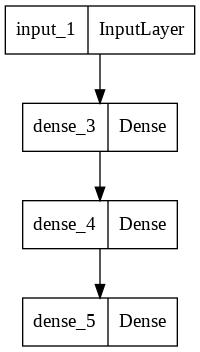

In [ ]:
tf.keras.utils.plot_model(model, "my_first_model.png")

### 저장 및 불러오기

여기는 지금 keras를 활용하는 예시를 보여드립니다. 다른 방법 더 어려운 방법도 있는데... 그건 찾아서 해보세요.


#### 아주 간단

In [ ]:
model.save('logs/modelsave')

In [ ]:
!ls logs/modelsave

assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
model=tf.keras.models.load_model('logs/modelsave')

#### 조금 복잡


In [ ]:
model_json = model.to_json()
with open("logs/jsonmodel.json","w") as f:
  f.write(model_json)

### Weight 가져오기


In [ ]:
import h5py

In [ ]:
model.save_weights("logs/weights")

In [ ]:
model.load_weights("logs/weights")
# model.compile(optimizer='',loss='',metric=['accuracy'])

In [ ]:
model.layers

In [ ]:
print(model.layers[1].get_weights()[0]) # Weights 
print(model.layers[1].get_weights()[1]) # Bias

[[-0.03102354  0.0253844   0.03585377 ...  0.00093344  0.04625168
   0.01857517]
 [ 0.00214243 -0.07051256 -0.04047816 ...  0.07055806 -0.02422447
  -0.01562254]
 [ 0.07098978 -0.02472326  0.01814716 ...  0.00533354  0.07702283
   0.05650414]
 ...
 [ 0.03487177  0.05695335 -0.00963511 ... -0.07839536  0.00668011
   0.06191491]
 [ 0.06497497  0.0205372   0.02894669 ...  0.04087958  0.05171899
   0.07548765]
 [-0.0106134   0.05860495  0.02781385 ...  0.07218467 -0.04765756
  -0.063014  ]]
[ 0.01560133  0.02389565  0.00421451 -0.00493954  0.01925607 -0.01051815
  0.01988975  0.03865892  0.00842896 -0.01755422  0.002327    0.00472078
  0.00555751  0.00700078  0.00075626  0.01335391  0.05058135  0.01704356
  0.00326373 -0.0040328   0.01484182 -0.01640788  0.01465462  0.04272395
  0.03328675  0.00611384 -0.03763952  0.02124497 -0.00971257 -0.00593838
  0.0476092   0.00791371  0.02085746 -0.00484924  0.01791726 -0.00791811
 -0.03646103  0.03669408  0.0107525   0.01330924  0.04930202 -0.004922

#### Hidden layer activity

좀 귀찮게도... Hidden layer 각각의 걸 추출하는 식을 만들어서 추출해야합니다.

In [ ]:
h_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)

In [ ]:
import numpy as np
h_extractor(np.random.uniform(0, 1, (1,784)).astype(np.float32))

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[0.8882901 , 1.5778987 , 1.4341819 , 0.        , 0.        ,
        0.        , 1.4025499 , 1.5185542 , 0.4624201 , 0.        ,
        0.21074158, 0.34377757, 0.1920734 , 0.        , 0.88879764,
        2.1959746 , 1.4562998 , 0.31291577, 2.5563393 , 0.        ,
        1.099066  , 0.        , 0.        , 0.99750584, 0.85278517,
        0.        , 0.6367853 , 2.746437  , 0.        , 0.04642073,
        0.        , 1.4089789 , 0.9447524 , 0.06947634, 1.151488  ,
        0.22125958, 0.8342876 , 0.978091  , 0.        , 0.4685971 ,
        0.8405887 , 0.        , 1.5993502 , 0.        , 0.0941684 ,
        1.6466273 , 0.        , 0.04832469, 0.29368365, 0.        ,
        0.7629724 , 0.01003119, 2.5103643 , 0.        , 0.54081756,
        1.1241224 , 1.3558011 , 0.        , 0.        , 0.        ,
        0.40310848, 0.        , 0.14098391, 1.4175414 , 0.        ,
        1.0652345 , 0.15856887, 0.        , 0.        , 1.3731018 

 ## 3.4. 더 해보기!!!!

 시간이 없어서 넘어가는데, 우리가 수업시간에 배운 것들을 테스트 해보면 좋습니다.

 

*   SGD vs 다른 optimizer의 test loss를 텐서보드에서 비교해봅시다.
    * 이걸 SGD 가 아닌 다른 optimizer 를 쓰면 빨리 하강? 천천히?
* ReLu vs 다른 활성함수




# 4. 과적합 해결


ReLu 는 한번씩 해보시구요, 여기서는 우리가 배운 내용중에


*   배치정규화
*   드랍아웃

이렇게 두개만 적용시켜볼게요. 왜냐면 중지 early termination 은 여러분이 하면서 텐서보드 보고 감을 잡아야 되는 거고 weight decay 는 요즘엔 그렇게 자주 쓰진 않아요. 그냥 그런것도 있다 정도로 알고만 계십시다?



일단 강제로 overfitting 모델 하나 만듭시다.

In [ ]:
# 만약 이미 저장된 값이 있으면 지웁시다.
!rm -rf logs_overfit/ #logs_overfit  폴더에 저장할거에요

In [ ]:
# 함수형 쓸때는 이렇게들 많이씁니다... 콜백이라고 해요 model.fit 할때 콜백해서 쓰려고 만드는 겁니다.
log_dir = "logs_overfit/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir logs_overfit

<IPython.core.display.Javascript object>

In [ ]:
inputs = tf.keras.Input(shape=(784,))
dense = Dense(128, activation="relu")
x = dense(inputs)
outputs = Dense(10)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

# 학습
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(lr = 0.8),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2, callbacks=[tensorboard_callback])

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 3s 4ms/step - loss: 0.3109 - accuracy: 0.9032 - val_loss: 0.1562 - val_accuracy: 0.9540
Epoch 2/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1293 - accuracy: 0.9600 - val_loss: 0.1292 - val_accuracy: 0.9647
Epoch 3/30
750/750 [==============================] - 3s 3ms/step - loss: 0.0971 - accuracy: 0.9700 - val_loss: 0.1524 - val_accuracy: 0.9523
Epoch 4/30
750/750 [==============================] - 3s 3ms/step - loss: 0.0770 - accuracy: 0.9760 - val_loss: 0.1208 - val_accuracy: 0.9644
Epoch 5/30
750/750 [==============================] - 3s 3ms/step - loss: 0.0655 - accuracy: 0.9790 - val_loss: 0.1071 - val_accuracy: 0.9708
Epoch 6/30
750/750 [==============================] - 2s 3ms/step - loss: 0.0551 - accuracy: 0.9823 - val_loss: 0.1106 - val_accuracy: 0.9710
Epoch 7/30
750/750 [==============================] - 3s 3ms/step - loss: 0.0444 - accuracy: 0.9855 - val_loss: 0.1199 - val_accuracy: 0.9690
Epoch 8/30
750/75

## 배치정규화

```
inputs = tf.keras.Input(shape=(784,))
dense = Dense(128, activation="relu")
x = dense(inputs)
x = tf.keras.layers.BatchNormalization()(x)
outputs = Dense(10)(x)
```

## 드랍아웃

```
inputs = tf.keras.Input(shape=(784,))
dense = Dense(128, activation="relu")
x = dense(inputs)
x = tf.keras.layers.Dropout(0.2)(x) # 20%로 버리겠다
outputs = Dense(10)(x)
```

## 둘다 적용하고 동일한 방식 학습

In [ ]:
# 만약 이미 저장된 값이 있으면 지웁시다.
!rm -rf logs_overfit_resolved/ #logs_overfit_resolved  폴더에 저장할거에요

In [ ]:
# 함수형 쓸때는 이렇게들 많이씁니다... 콜백이라고 해요 model.fit 할때 콜백해서 쓰려고 만드는 겁니다.
log_dir = "logs_overfit_resolved/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir logs_overfit_resolved

<IPython.core.display.Javascript object>

In [ ]:
inputs = tf.keras.Input(shape=(784,))
dense = Dense(128, activation="relu")
x = dense(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(10)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

# 학습
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(lr = 0.8),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2, callbacks=[tensorboard_callback])

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 102,282
Trainable params: 102,026
Non-trainable params: 256
_______________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 4s 4ms/step - loss: 0.3024 - accuracy: 0.9072 - val_loss: 0.1698 - val_accuracy: 0.9501
Epoch 2/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1818 - accuracy: 0.9441 - val_loss: 0.1538 - val_accuracy: 0.9559
Epoch 3/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1564 - accuracy: 0.9524 - val_loss: 0.1130 - val_accuracy: 0.9661
Epoch 4/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1378 - accuracy: 0.9565 - val_loss: 0.1050 - val_accuracy: 0.9684
Epoch 5/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1230 - accuracy: 0.9620 - val_loss: 0.1045 - val_accuracy: 0.9697
Epoch 6/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1146 - accuracy: 0.9632 - val_loss: 0.1011 - val_accuracy: 0.9722
Epoch 7/30
750/750 [==============================] - 3s 4ms/step - loss: 0.1062 - accuracy: 0.9671 - val_loss: 0.0976 - val_accuracy: 0.9726
Epoch 8/30
750/75